In [1]:
import numpy as np
import pandas as pd

# For plotting
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from adjustText import adjust_text

# Import relevant scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, pairwise_distances_argmin
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
## Define path and csv files
DATA_DIR = './'
DATA = 'Keq-solvents.csv'

df = pd.read_csv(DATA_DIR + DATA)

## Train and Test split with PCA clusters

In [8]:
## Select numerical and x-variables only 
numeric_data = df.select_dtypes(include=['number'])
numeric_xdata = numeric_data.drop(columns=['dG'])    # original numerical data
names = df['solvent']
print(df.shape, numeric_xdata.shape)


## Scale data
scaler = StandardScaler()
numeric_xdata[numeric_xdata.columns] = scaler.fit_transform(numeric_data[numeric_xdata.columns])
print(numeric_xdata.head())     # scaled numerical data


(20, 19) (20, 17)
          n      beta     gamma  dielectric  dispersion     polar  hydrogen  \
0  0.207955 -0.821259 -0.877856   -0.793914    0.301971 -0.904461 -0.886339   
1 -0.925088 -1.354792 -1.396205   -0.818993   -0.339085 -1.132408 -1.529779   
2  2.196180  1.084215  1.636433   -0.342474   -3.881760  2.091413  0.304026   
3 -2.102236 -0.135289 -0.752738    1.475846   -0.609003  1.798338  0.432714   
4 -0.188990  1.503419  1.228904    1.224574    0.301971  0.870269  0.786606   

        sum  MV_boltz      area    volume    dipole      Sig2      Sig3  \
0 -0.939140 -0.143627 -0.208528 -0.191156 -0.961568 -0.785993 -0.803264   
1 -1.610406  2.450064  3.150535  3.017168 -1.197103 -1.371497 -0.803929   
2  0.289405  0.726822  0.374705  0.514870  0.167566  0.591715  0.185807   
3  1.340633 -1.509692 -1.663399 -1.765797  1.013908  0.620063 -0.079439   
4  1.099991 -0.346228 -0.237603 -0.261716  1.350045  1.464831  2.115259   

   Hbond_acc         B         V  
0  -0.844515 -0.81043

In [18]:
## Reduce dimensions from 20 dimensions to n_components
pca = PCA(n_components=2)  
projected = pca.fit_transform(numeric_xdata)
print(projected.shape)

(20, 2)


In [19]:
## Split data into Train-Test data sets based on range of clusters

for n_clusters in range(5,15):
    
    kmeans = KMeans(n_clusters)    
    kmeans.fit(projected)
    cluster = kmeans.predict(projected)
    centers = kmeans.cluster_centers_
        
    PCA_clusters = []
    for i, cl in enumerate(cluster):
        dist = np.sqrt((projected[:, 0][i]-centers[:, 0][cl])**2 + (projected[:, 1][i]-centers[:, 1][cl])**2)
        substrate =  names[i]
        PCA_clusters.append([cl, substrate, dist])

    df_s = pd.DataFrame(PCA_clusters)
    l = df_s.loc[df_s.groupby(0)[2].idxmin()]  
    train = l[1].to_numpy()
#     print('PCA reactions for ', n_clusters, 'clusters: ', l[1].to_numpy()) 

    # split into Train and Test
    X = np.asarray(df['solvent'])
    test = []
    df[f'{n_clusters} k_clusters'] = range(20)
    for j, sample in enumerate(X):
        if sample not in train:
            df[f'{n_clusters} k_clusters'][j] = 'TEST'
            test.append(sample)
        else: 
            df[f'{n_clusters} k_clusters'][j] = 'TRAIN'
    print(f'{len(train)} Train : {len(test)} Test samples\n')
    

5 Train : 15 Test samples

6 Train : 14 Test samples

7 Train : 13 Test samples

8 Train : 12 Test samples

9 Train : 11 Test samples

10 Train : 10 Test samples

11 Train : 9 Test samples

12 Train : 8 Test samples

13 Train : 7 Test samples

14 Train : 6 Test samples



In [20]:
## Save dataframe of split-labels per cluster
df
# df.to_csv("Keq-solvents-pca-split.csv", index=False)


## R2, Q2, and RMSE plots
After statistical analysis for all of the train and test split, the data was imported for plotting.

In [21]:
STAT_DATA = 'TableS20.csv'  # Data imported after statistical analysis with R

stat_df = pd.read_csv(DATA_DIR + STAT_DATA)
stat_num = stat_df.select_dtypes(include=['number'])
r2_df = stat_num.drop(columns=['R2_rmse', 'Q2_rmse'])
rmse_df = stat_num.drop(columns=['R2_train', 'Q2_test'])

print(stat_num.head())
print(r2_df.shape, rmse_df.shape)


   cluster  R2_train  R2_rmse  Q2_test  Q2_rmse
0        5      0.94     0.11     0.17     0.49
1        6      0.93     0.11     0.58     0.35
2        7      0.88     0.14     0.60     0.34
3        8      0.78     0.21     0.53     0.36
4        9      0.92     0.14     0.43     0.35
(10, 3) (10, 3)


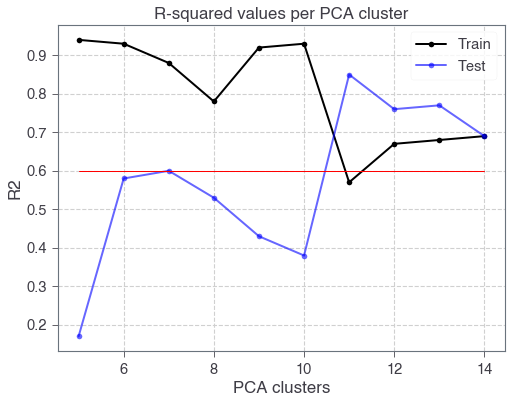

In [31]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='paper', fscale=1.4, spines=True, ticks=True, gridlines='--') 

## Figures S36 - R2 and Q2 results
plt.figure(figsize=(8, 6))
plt.plot(r2_df["cluster"], r2_df["R2_train"], marker='o', markerfacecolor='black', linewidth=2, c='black', linestyle='-', label="Train")
plt.plot(r2_df["cluster"], r2_df["Q2_test"], c='blue', marker='o', markerfacecolor='blue', linewidth=2, linestyle='-', alpha=0.6, label="Test")
plt.plot([5,14], [0.6,0.6] , c='red', linewidth=1)
# plt.plot([5,14], [0.7,0.7] , c='green', linewidth=1)


plt.title('R-squared values per PCA cluster')
plt.ylabel('R2')
plt.xlabel('PCA clusters')
plt.legend();
# plt.savefig('figureS36_r2.png',dpi=300)


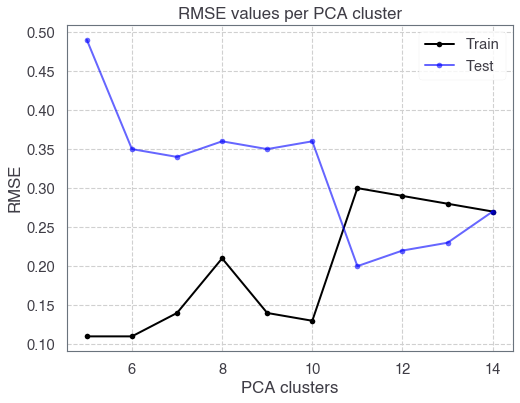

In [24]:
## Figures S36 - RMSE results

plt.figure(figsize=(8, 6))
plt.plot(rmse_df["cluster"], rmse_df["R2_rmse"], marker='o', markerfacecolor='black', linewidth=2, c='black', linestyle='-', label="Train")
plt.plot(rmse_df["cluster"], rmse_df["Q2_rmse"], c='blue', marker='o', markerfacecolor='blue', linewidth=2, linestyle='-', alpha=0.6, label="Test")


plt.title('RMSE values per PCA cluster')
plt.ylabel('RMSE')
plt.xlabel('PCA clusters')
plt.legend();
# plt.savefig('figureS36_rmse.png',dpi=300)


## PCA plot - Solvent distribution highlighted by k-cluster
The following solvent distribution plot was based on selected k-means clustering split of train and test data.

In [25]:
jtplot.style(theme='grade3', context='paper', fscale=1.4, spines=True, ticks=True, gridlines='--') 

## PCA clustering using 10 clusters
number_of_clusters = 12

kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(projected)
cluster = kmeans.predict(projected)
centers = kmeans.cluster_centers_


## Descriptors contribution to PC1 and PC2

In [26]:
## TableS19 - Eigenvectors associated with the first two principal components
feature_names = numeric_xdata.columns

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=feature_names)
loadings_sorted = loadings.sort_values(['PC1', 'PC2'], ascending=[False, False])
print(loadings_sorted, '\n')

# loadings_sorted.to_csv('TableS19.csv')

                 PC1       PC2
sum         0.299655  0.017232
Sig2        0.294766  0.141949
B           0.276359  0.174948
hydrogen    0.274635  0.040493
beta        0.273799  0.203513
Sig3        0.268045  0.148921
Hbond_acc   0.265258  0.165144
dielectric  0.257220  0.027441
polar       0.252948  0.164918
dipole      0.240336  0.078282
gamma       0.206371  0.240407
dispersion -0.013924 -0.338308
n          -0.027791  0.250799
area       -0.227660  0.395287
volume     -0.233910  0.394717
V          -0.236311  0.387222
MV_boltz   -0.245965  0.353861 



PCA reactions for  12 clusters:  ['chlorobenzene' '1,4-dioxane' 'DMF' 'dodecane' 'quinoline'
 'dibutyl ether' 'mesitylene ' 'acetonitrile ' 'nitrobenzene '
 'cyclohexane' 'DMSO' 'anisole']

Explained variation per principal component: 60% and 15%


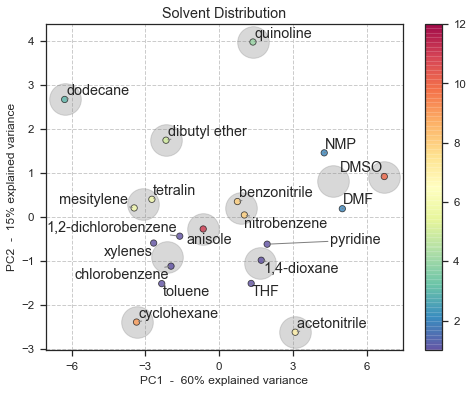

In [29]:
## Figure S35 - PCA plot of solvent distribution at 10 clusters
PCA_clusters = []
for i, cl in enumerate(cluster):
    dist = np.sqrt((projected[:, 0][i]-centers[:, 0][cl])**2 + (projected[:, 1][i]-centers[:, 1][cl])**2)
    substrate =  names[i]
    PCA_clusters.append([cl, substrate, dist])

df_s = pd.DataFrame(PCA_clusters)
l = df_s.loc[df_s.groupby(0)[2].idxmin()]  
print('PCA reactions for ', number_of_clusters, 'clusters: ', l[1].to_numpy())  

plt.figure(figsize=(8, 6))
plt.grid(linestyle='--', linewidth=1)
sns.set(font_scale=1.2, style="ticks") 
plt.scatter(centers[:, 0], centers[:, 1], c='gray', s=1000, alpha=0.3)  # centroids
points = plt.scatter(projected[:, 0], projected[:, 1],
            c=df_s[0], edgecolor='k', linewidths=0.8, s=40, alpha=0.8,
            cmap='Spectral_r', )

pc1 = round(pca.explained_variance_ratio_[0]*100)
pc2 = round(pca.explained_variance_ratio_[1]*100)
print(f'\nExplained variation per principal component: {pc1}% and {pc2}%')


plt.xlabel(f'PC1  -  {pc1}% explained variance',fontsize=12)
plt.xticks(fontsize=11.5)
plt.xticks([-6, -3, 0, 3, 6]) 
plt.ylabel(f'PC2  -  {pc2}% explained variance',fontsize=12)
plt.yticks(fontsize=11.5)

# Colorbar format
plt.clim(1, number_of_clusters) 
color_ax = plt.colorbar(points)
color_ax.ax.tick_params(labelsize=11.5)
 
texts = [plt.text(projected[:, 0][i], projected[:, 1][i], txt, ha='center', va='center') for i, txt in enumerate(names)]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray')) 
     

plt.title('Solvent Distribution');
# plt.savefig('figureS35-PCA-clustering-split.png', dpi=400, bbox_inches='tight')


In [67]:
texts

[Text(-2.2870627857551393, -1.5412722679105086, 'toluene'),
 Text(-6.218593176590521, 2.7067431641117086, 'dodecane'),
 Text(1.4323735173560037, 4.007881161453724, 'quinoline'),
 Text(3.167174218146051, -2.5834507877563366, 'acetonitrile '),
 Text(4.304133696264118, 1.493593136166138, 'NMP'),
 Text(1.7871121473221196, -1.0096458930237915, '1,4-dioxane'),
 Text(-1.699965916438671, -0.4005312958612183, '1,2-dichlorobenzene'),
 Text(-0.602639929715898, -0.29920137383055834, 'anisole'),
 Text(-3.278848664952335, -2.3525293482527143, 'cyclohexane'),
 Text(-2.082930444624245, 1.780468412307072, 'dibutyl ether'),
 Text(5.280947625957278, 0.5321944953457927, 'DMF'),
 Text(6.672554118671589, 0.9551492725483552, 'DMSO'),
 Text(-3.5291333426769964, 0.24138887766057576, 'mesitylene '),
 Text(1.4441759398153249, 0.3803737843669252, 'nitrobenzene '),
 Text(-2.051834128934456, -1.1439146801021964, 'chlorobenzene'),
 Text(-0.8661109537142868, 0.7815867268082116, 'benzonitrile'),
 Text(2.00284339453512

## PCA plot highlighed by experimental yield

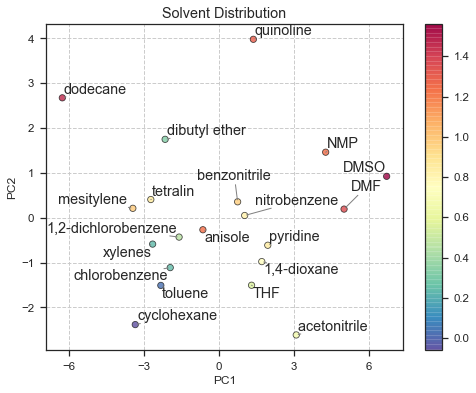

In [30]:
## Scheme1C 
dG_exp = numeric_data['dG']

plt.figure(figsize=(8, 6))
plt.grid(linestyle='--', linewidth=1)
sns.set(font_scale=1.2, style="ticks") 
points = plt.scatter(projected[:, 0], projected[:, 1],
            c=dG_exp, edgecolor='k', linewidths=0.8, s=40, alpha=0.8,
            cmap='Spectral_r', )  

plt.xlabel(f'PC1',fontsize=12)
plt.xticks(fontsize=11.5)
plt.xticks([-6, -3, 0, 3, 6]) 
plt.ylabel(f'PC2',fontsize=12)
plt.yticks(fontsize=11.5)

color_ax = plt.colorbar(points)
color_ax.ax.tick_params(labelsize=11.5)
 
texts = [plt.text(projected[:, 0][i], projected[:, 1][i], txt, ha='center', va='center') for i, txt in enumerate(names)]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray')) 
     

plt.title('Solvent Distribution');
# plt.savefig('scheme1C-PCA.png', dpi=400, bbox_inches='tight')


## Additional plots

In [73]:
df.columns

Index(['solvent', 'dG', 'n', 'beta', 'gamma', 'dielectric', 'dispersion',
       'polar', 'hydrogen', 'sum', 'MV_boltz', 'area', 'volume', 'dipole',
       'Sig2', 'Sig3', 'Hbond_acc', 'B', 'V', '5 k_clusters', '6 k_clusters',
       '7 k_clusters', '8 k_clusters', '9 k_clusters', '10 k_clusters',
       '11 k_clusters', '12 k_clusters', '13 k_clusters', '14 k_clusters'],
      dtype='object')

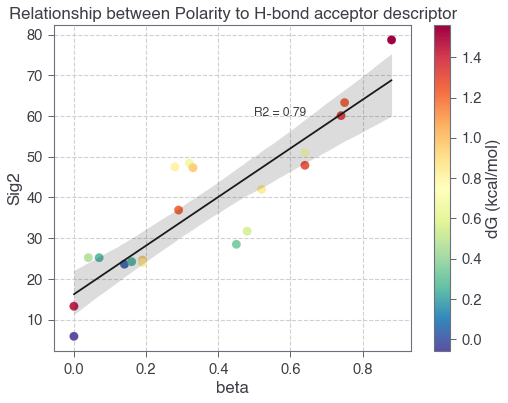

In [35]:
## FigureS37 - Relationships for polarity (Sig2) and McGowan’s characteristic volume (V)
dG_exp = numeric_data['dG']
beta = numeric_data['beta']
Sig2 = numeric_data['Sig2']

plt.figure(figsize=(8, 6))
points = plt.scatter(beta, Sig2,
                     c=dG_exp, s=75, cmap="Spectral_r")
sns.regplot(x="beta", y="Sig2", data=numeric_data, scatter=False, color=".1");


plt.title('Relationship between Polarity to H-bond acceptor descriptor')
plt.text(0.5, 60, 'R2 = 0.79', fontsize=12)
plt.ylabel('Sig2')
plt.xlabel('beta')
plt.colorbar(points, label="dG (kcal/mol)");
# plt.savefig('figureS37.png',dpi=300)

In [54]:
## Defining variables for FigureS38
arom_solvs = [ df['solvent'][0], df['solvent'][19], df['solvent'][12] ]
alp_solvs = [ df['solvent'][8], df['solvent'][1] ]

dGs_arom = [ df['dG'][0], df['dG'][19], df['dG'][12] ]
dGs_alp = [ df['dG'][8], df['dG'][1] ]

Vs_arom = [ df['V'][0], df['V'][19], df['V'][12] ]
Vs_alp = [ df['V'][8], df['V'][1] ]

<Figure size 648x504 with 0 Axes>

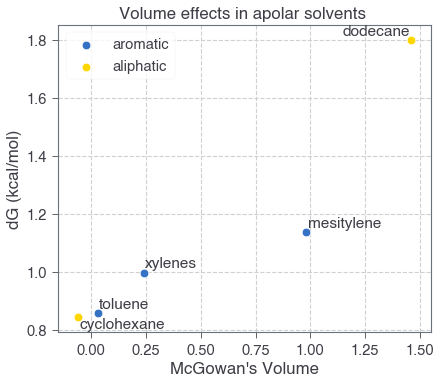

In [70]:
## FigureS38 - Volume effects (contribution) in APOLAR SOLVENTS
McGowan_V = numeric_data['V']

plt.figure(figsize=(9, 7))
fig, ax = plt.subplots()
#sns.regplot(x=df["V"][0:3], y=df["dG"][0:3], data=df, color="black", ci=None)
sns.scatterplot(x=dGs_arom, y=Vs_arom, data=df, s=75, label="aromatic");
sns.scatterplot(x=dGs_alp, y=Vs_alp, data=df, s=75, color="gold", label="aliphatic");

texts = [ plt.text(df["dG"][i], df["V"][i], txt, ha='center', va='center') for i, txt in enumerate(names) if txt in arom_solvs or txt in alp_solvs]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray')) 
    
plt.title('Volume effects in apolar solvents ')
plt.ylabel('dG (kcal/mol)')
plt.xlabel("McGowan's Volume");
plt.tight_layout()
# plt.savefig('figureS38.png',dpi=200)

In [10]:
## Load partion data
df_apolar = df = pd.read_csv('partion_apolar-solvents.csv')
df_apolar.head()

,solvent,LogP,V,Component
0,toluene,0.344151,0.8573,Styrene
1,xylenes,0.422823,0.9982,Styrene
2,mesitylene,0.510290,1.1391,Styrene
3,dodecane,1.567200,1.7994,Styrene
4,cyclohexane,0.758232,0.8454,Styrene


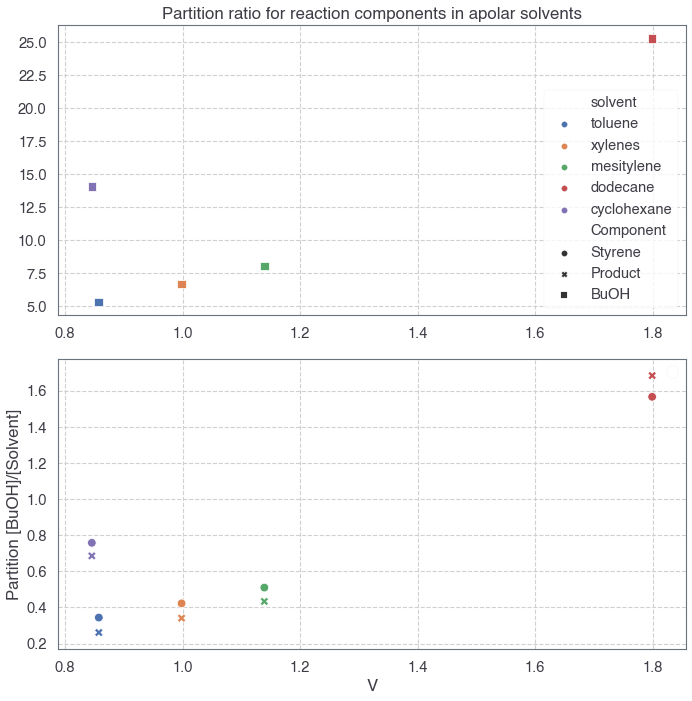

In [12]:
# FigureS39 - Partion ratio plot of simulated mixture of n-BuOH and apolar solvent
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='paper', fscale=1.4, spines=True, ticks=True, gridlines='--') 

plt.figure(figsize=(10, 10))
plt.subplot(211)
sns.scatterplot(df_apolar["V"][10:], df_apolar["LogP"][10:], data=df_apolar, hue="solvent", style="Component", s=75, palette="deep")
plt.title('Partition ratio for reaction components in apolar solvents');
plt.ylabel('')
plt.xlabel('')

plt.subplot(212)
sns.scatterplot(df_apolar["V"][0:10], df_apolar["LogP"][0:10], data=df_apolar, hue="solvent", style="Component", s=75, palette="deep")
    
plt.ylabel('Partition [BuOH]/[Solvent]')
plt.xlabel('V')
plt.legend([])
plt.tight_layout();
# plt.savefig('P-vs-volume-solvents.png',dpi=200)